In [2]:
using DataFrames, NPZ, Arrow, JLD2
using Statistics, NaNMath
using Plots, StatsPlots
using DifferentialEquations, DiffEqParamEstim, Optim

G(z, zstar) = z < zstar ? z : zstar 
@register G(z, zstar)

"""
Interface limited model for biofilm growth,
assumes that nutrients are infinite
"""
function interface_limited(du, u, p, t)
    h = u[1] 
    α, β, hstar = p
    du[1] = α*G.(h, hstar) - β*h 
    return du
end

"""
Fits the experimental data to the interface 
limited interface model. Returns the best parameters
growth, decay and critical height
"""
function fit_model(prob, tdata, zdata, p)
    # Set problem + dummy parameters
    cost_function = build_loss_objective(prob, Tsit5(), L2Loss(tdata, zdata),
                    maxiters=100000, verbose=false)
    result_bfgs = Optim.optimize(cost_function, p, Optim.BFGS())
    min = result_bfgs.minimizer
    return min 
end

function get_data(Df, strain, repl)
    df =  filter(row -> row.Replicate .== repl && row.Strain .== strain, Df);
    return df.Time, df.avg_height, df.max_height
end


_nanfunc(f, A, ::Colon) = f(filter(!isnan, A))
_nanfunc(f, A, dims) = mapslices(a->_nanfunc(f,a,:), A, dims=dims)
nanfunc(f, A; dims=:) = _nanfunc(f, A, dims)

nanfunc (generic function with 1 method)

In [3]:
Df = jldopen("/home/pablo/Documents/GitHub/biofilm_surface_growth/data/timelapses/profile_database.jld2", "r")["df"];
Df[557+40, 13] = 172
Df[557+43, 13] = 200
Df[557+44, 13] = 190
Df[557+45, 13] = 180
Df[557+46, 13] = 197
Df[557+47, 13] = 210

# Set problem + dummy parameters
u0, p = [0.1], [0.9, 0.1, 20] # Dummy starting conditions
prob = ODEProblem(interface_limited, u0, (0.0, 50.0), p) # Set the problem

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (0.0, 50.0)
u0: 1-element Vector{Float64}:
 0.1

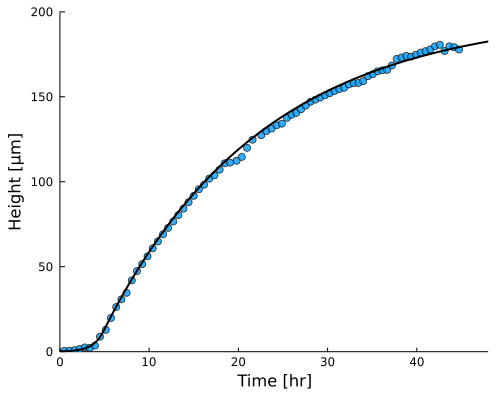

In [66]:
t, h, hm = get_data(Df, "JT1080", "B")

h = abs.(h)
p1 = scatter(t, h, alpha=0.8, xlabel="Time (hr)", ylabel="Height [μm]", label=false, ylim=(0, 200))

p = [0.93, 0.056, 12.0]
u0 = 0.17
prob = ODEProblem(interface_limited, [u0], (0.0, 50.0), p) # Set the problem
sol = solve(prob, saveat=0.01)
p1 = plot!(sol, color=:black, linewidth=2, xlabel="Time [hr]", label=false, xlim=(0, 48), ylim=(0, 200), grid=false)

p2 = scatter(t, h, alpha=0.65, xlabel="Time (hr)", ylabel="Height [μm]", label=false, ylim=(0.1, 250), xlim=(0, 48), yscale=:log10)
p2 = plot!(sol, color=:black, linewidth=2, xlabel="Time [hr]", label=false, xlim=(0, 48), ylim=(0.1, 255), grid=false)
plot(p1, size=(500, 400), dpi=300)
#plot(p1, p2, size=(1000, 350))
#savefig("/home/pablo/Documents/GitHub/biofilm_surface_growth/figs/timelapses/interface_linear.svg")

In [77]:
plot(p2, size=(300, 250), dpi=300)
savefig("/home/pablo/Documents/GitHub/biofilm_surface_growth/figs/timelapses/interface_log.svg")

In [129]:
get_derivs(h, t) = (h[2:end]-h[1:end-1]) ./ (t[2:end] - t[1:end-1])

p1 = plot()
replicates = ["A", "B", "C"]
for i=1:3
    t, h, hm = get_data(Df, "SN503", replicates[i])
    hprime = get_derivs(h, t)
    hmprime = get_derivs(hm, t)

    p1 = scatter!(h[1:end-1], hprime, color=i, alpha=0.8, label=replicates[i], marker=:circle)
    #p1 = scatter!(hm[1:end-1], hmprime, color=i, alpha=0.8, label=false, marker=:diamond)
end
plot(p1, grid=false, xlabel="Height [μm]", ylabel="ΔHeight [μm/hr]", size=(500, 350), dpi=300, ylim=(-3, 13))
savefig("/home/pablo/Documents/GitHub/biofilm_surface_growth/figs/timelapses/dh_height.svg")

In [127]:
p1 = plot()
for i=1:3
    t, h, hm = get_data(Df, "SN503", replicates[i])
    hprime = get_derivs(h, t)
    hmprime = get_derivs(hm, t)

    p1 = scatter!(t[1:end-1], hprime, color=i, alpha=0.8, label=replicates[i], marker=:circle)
    #p1 = scatter!(t[1:end-1], hmprime, color=i, alpha=0.8, label=false, marker=:diamond)

end
plot(p1, grid=false, xlabel="Time [hr]", ylabel="ΔHeight [μm/hr]", size=(500, 350), dpi=300, xlim=(0, 48), ylim=(-3, 13))
savefig("/home/pablo/Documents/GitHub/biofilm_surface_growth/figs/timelapses/dh_time_all.svg")

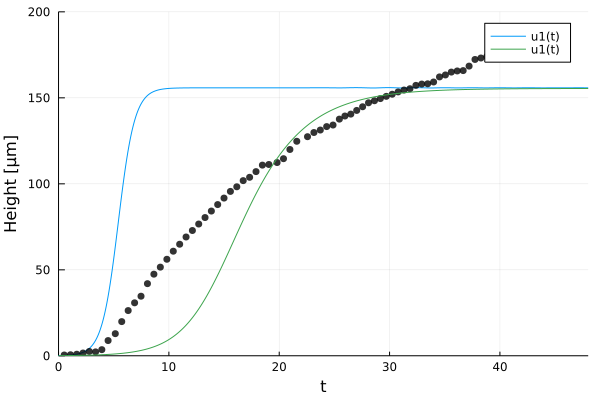

In [143]:
function logistic_growth(du, u, p, t)
    h, c = u[1], u[2] 
    α, K_h, ϵ, K_c  = p
    du[1] = α*h*(1-h/K_h)*(c/(K_c+c))
    du[2] = -ϵ*α*h*(1-h/K_h)*(c/(K_c+c))
    return du
end

t, h, hm = get_data(Df, "JT1080", "B")
#t, h = t[1:12], h[1:12]

u0 = [0.1, 100.0]
p = [1.4, 155.81, 0.3, 3.1]
prob = ODEProblem(logistic_growth, u0, (0.0, 48.0), p) # Set the problem
sol = solve(prob, save_idxs=1)
plot(sol)
scatter!(t, h, alpha=0.8, xlabel="Time (hr)", ylabel="Height [μm]", color=:black, label=false, ylim=(0, 200))

cost_function = build_loss_objective(prob, Tsit5(), L2Loss(t, h),
                maxiters=100000, verbose=false)
result_bfgs = Optim.optimize(cost_function, p, Optim.BFGS(linesearch=LineSearches.BackTracking()))
min = abs.(result_bfgs.minimizer)

prob = ODEProblem(logistic_growth, u0, (0.0, 48.0), min) # Set the problem
sol = solve(prob, save_idxs=1)
plot!(sol)

In [145]:
min

4-element Vector{Float64}:
   7.60193836781877e7
 155.46971949697206
   0.30089305391345833
   1.639359499271662e10

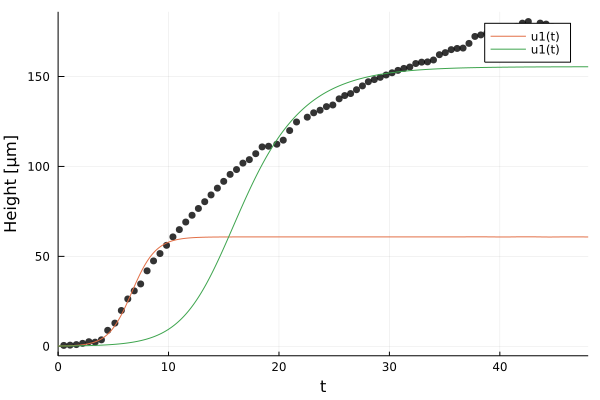

In [160]:
scatter(t, h, alpha=0.8, xlabel="Time (hr)", ylabel="Height [μm]", color=:black, label=false)

t, h, hm = get_data(Df, "JT1080", "B")

u0 = [0.1, 100.0]
p = [1.35, 60.81, 0.4, 40.0]
prob = ODEProblem(logistic_growth, u0, (0.0, 48.0), p) # Set the problem
sol = solve(prob, save_idxs=1)
plot!(sol)

t, h, hm = get_data(Df, "JT1080", "B")

u0 = [0.1, 100.0]
p = [7.60193836781877e7
 155.46971949697206
   0.30089305391345833
   1.639359499271662e10]
prob = ODEProblem(logistic_growth, u0, (0.0, 48.0), p) # Set the problem
sol = solve(prob, save_idxs=1)
plot!(sol)


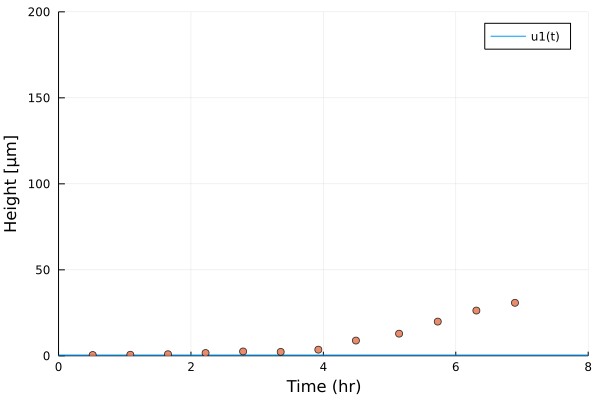

In [56]:
prob = ODEProblem(logistic_growth, u0, (0.0, 8.0), min) # Set the problem
sol = solve(prob, save_idxs=1)
plot(sol)
scatter!(t, h, alpha=0.8, xlabel="Time (hr)", ylabel="Height [μm]", label=false, ylim=(0, 200))

In [78]:
function seor(sol, t, h)
    h_regression = reduce(vcat, sol.(t))
    return abs.(h - h_regression)
end

seor (generic function with 1 method)

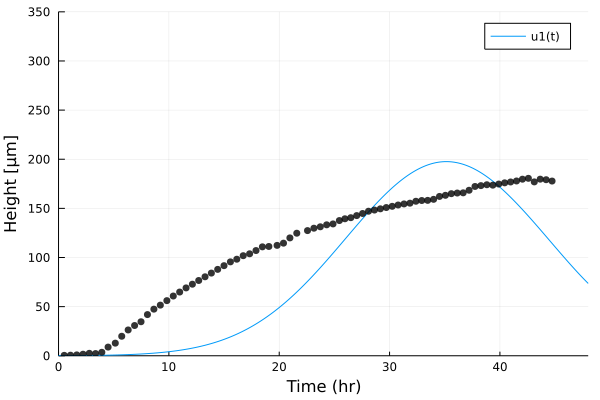

In [333]:
function nutrient_limited(du, u, p, t)
    h, c = u[1], u[2] 
    α, β, ϵ, K_c  = p
    du[1] = α*h*(c/(K_c+c)) - β*h
    du[2] = -ϵ*α*(c/(K_c+c))
    return du
end

t, h, hm = get_data(Df, "JT1080", "B")
#t, h = t[1:12], h[1:12]

u0 = [0.1, 150.0]
p = [3.0, 0.2381, 10.51, 253.1]
prob = ODEProblem(nutrient_limited, u0, (0.0, 48.0), min) # Set the problem
sol = solve(prob, save_idxs=1)
plot(sol)
scatter!(t, h, alpha=0.8, xlabel="Time (hr)", ylabel="Height [μm]", color=:black, label=false, ylim=(0, 350))


In [332]:
cost_function = build_loss_objective(prob, Tsit5(), L2Loss(t, h),
                maxiters=100000, verbose=false)
result_bfgs = Optim.optimize(cost_function, p, Optim.BFGS(linesearch=LineSearches.BackTracking()))
min = (result_bfgs.minimizer)


4-element Vector{Float64}:
  37.86174914536388
   4.607643816150424
   0.08717438273580702
 975.9137396347359

In [378]:
t, h, hm = get_data(Df, "JT1080", "B")

h = abs.(h)
p1 = scatter(t, h, alpha=0.8, xlabel="Time (hr)", ylabel="Height [μm]", label=false, ylim=(0, 200), color=:black)

p = [0.93, 0.056, 12.0]
u0 = 0.17
prob = ODEProblem(interface_limited, [u0], (0.0, 50.0), p) # Set the problem
sol_interface = solve(prob)

p = [7.60193836781877e7, 155.46971949697206, 0.30089305391345833, 1.639359499271662e10]
u0 = [0.1, 100.0]
prob = ODEProblem(logistic_growth, u0, (0.0, 48.0), p) # Set the problem
sol_logistic = solve(prob, save_idxs=1)

p = [37.86174914536388, 4.607643816150424, 0.08717438273580702, 975.9137396347359]
u0 = [0.1, 150.0]
prob = ODEProblem(nutrient_limited, u0, (0.0, 48.0), p) # Set the problem
sol_nutrient = solve(prob, save_idxs=1)

#p1 = plot!(sol_interface, color=1, linewidth=2, xlabel="Time [hr]", yscale=:log, legend=:topleft, label="Interface", xlim=(0, 48), ylim=(0.1, 200), grid=false)
#p1 = plot!(sol_logistic, color=2, linewidth=2, label="Logistic")
#p1 = plot!(sol_nutrient, color=3, linewidth=2, label="Nutrient", legend=:topleft)

h_interface = reduce(vcat, sol_interface.(t))
h_logistic = reduce(vcat, sol_logistic.(t))
h_nutrient = reduce(vcat, sol_nutrient.(t))

#for i=1:length(t)
#   p1 = plot!([t[i], t[i]], [h_interface[i], h[i]], linewidth=1, color=1, label=false, alpha=0.4) 
#   p1 = plot!([t[i], t[i]], [h_logistic[i], h[i]], linewidth=1, color=2, label=false, alpha=0.4) 
#   p1 = plot!([t[i], t[i]], [h_nutrient[i], h[i]], linewidth=1, color=3, label=false, alpha=0.4) 
#end


plot(p1, size=(800, 400), dpi = 300, xlabel="Time [hr]", grid=false, left_margin=3mm, xlim=(0, 48))
savefig("/home/pablo/Documents/GitHub/biofilm_surface_growth/figs/timelapses/sequence_0.svg")

In [365]:
S_interface = abs.(reduce(vcat, sol_interface.(t))-h)
S_logistic = abs.(reduce(vcat, sol_logistic.(t))-h)
S_nutrient = abs.(reduce(vcat, sol_nutrient.(t))-h)

p3 = plot(t, S_interface, color=1, linewidth=1.5, grid=false, label=false)
p3 = plot!(t, S_logistic, color=2, linewidth=1.5, label=false)
p3 = plot!(t, S_nutrient, color=3, linewidth=1.5, label=false)

plot(p3, xlabel="Time[hr]", ylabel="S [μm]", size=(800, 150), xlim=(0, 48), dpi=300, bottom_margin=5mm, left_margin=5mm)
savefig("/home/pablo/Documents/GitHub/biofilm_surface_growth/figs/timelapses/seor.svg")

In [379]:
mean(S_interface), mean(S_logistic), mean(S_nutrient)

(1.857459552238525, 16.81949788599876, 35.479097176759254)

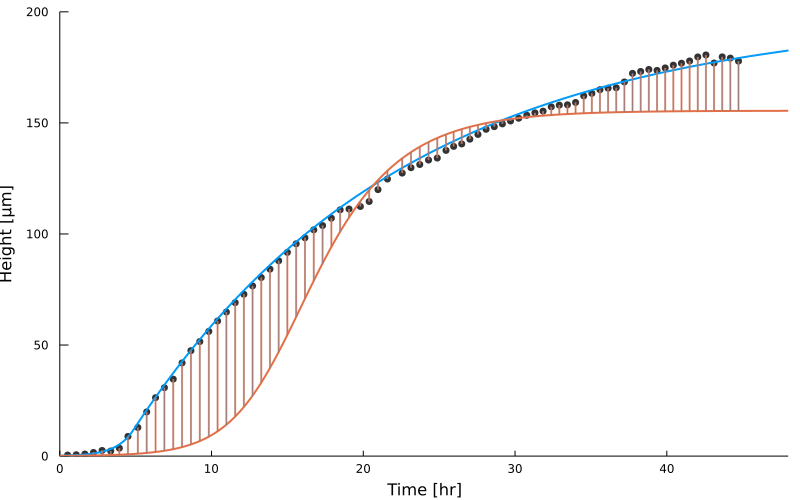

In [229]:
plot(p1, size=(500, 400), dpi=300)
h_interface = reduce(vcat, sol_logistic.(t))
h_logistic = reduce(vcat, sol_logistic.(t))
for i=1:length(t)
   p1 = plot!([t[i], t[i]], [h_interface[i], h[i]], linewidth=1, color=1, label=false) 
   p1 = plot!([t[i], t[i]], [h_logistic[i], h[i]], linewidth=2, color=2, label=false, alpha=0.7) 
end
#p1 = plot!(t, S_interface, color=1)
#p1 = plot!(t, S_logistic, color=2)

plot(p1, size=(800, 500))

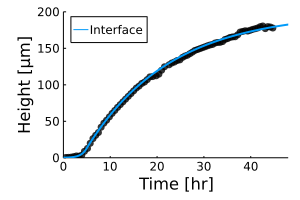

In [369]:
plot(p1, size=(300, 200), dpi = 300, xlabel="Time [hr]", grid=false, left_margin=3mm)
